In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import matplotlib.dates as mdates

db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "your_password",
    database = "ecommerce"
)

cur = db.cursor()


In [2]:
# Let's create a function wich will take our queries and return the output of those
def query_result(query):
    cur.execute(query)
    data = cur.fetchall()
    return data

### List all unique cities where customers are located

In [3]:
query = """
    SELECT DISTINCT customer_city
    FROM customers
"""

data = query_result(query)

In [4]:
df = pd.DataFrame(data, columns=['Countries'])
df.head(10)

,Countries
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


### Count the number of orders placed in 2017.

In [5]:
query = """
    SELECT COUNT(order_id)
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2017
"""

data = query_result(query)

In [6]:
print(f"Total number of order placed in 2017 is {data[0][0]}")

Total number of order placed in 2017 is 45101


### Find the total sales per category.

In [7]:
query = """
    SELECT 
    	UPPER(pr.product_category), 
    	ROUND(SUM(pa.payment_value), 2) AS sales
    FROM order_items AS o
    JOIN payments AS pa 
    	ON o.order_id = pa.order_id
    JOIN products as pr
    	ON o.product_id = pr.product_id
    GROUP BY pr.product_category
"""

data = query_result(query)

In [8]:
df = pd.DataFrame(data, columns = ['product_category', 'sales']).sort_values(by='sales', ascending=False)
df.head()

,product_category,sales
3,BED TABLE BATH,1712553.67
11,HEALTH BEAUTY,1657373.12
5,COMPUTER ACCESSORIES,1585330.45
1,FURNITURE DECORATION,1430176.39
15,WATCHES PRESENT,1429216.68


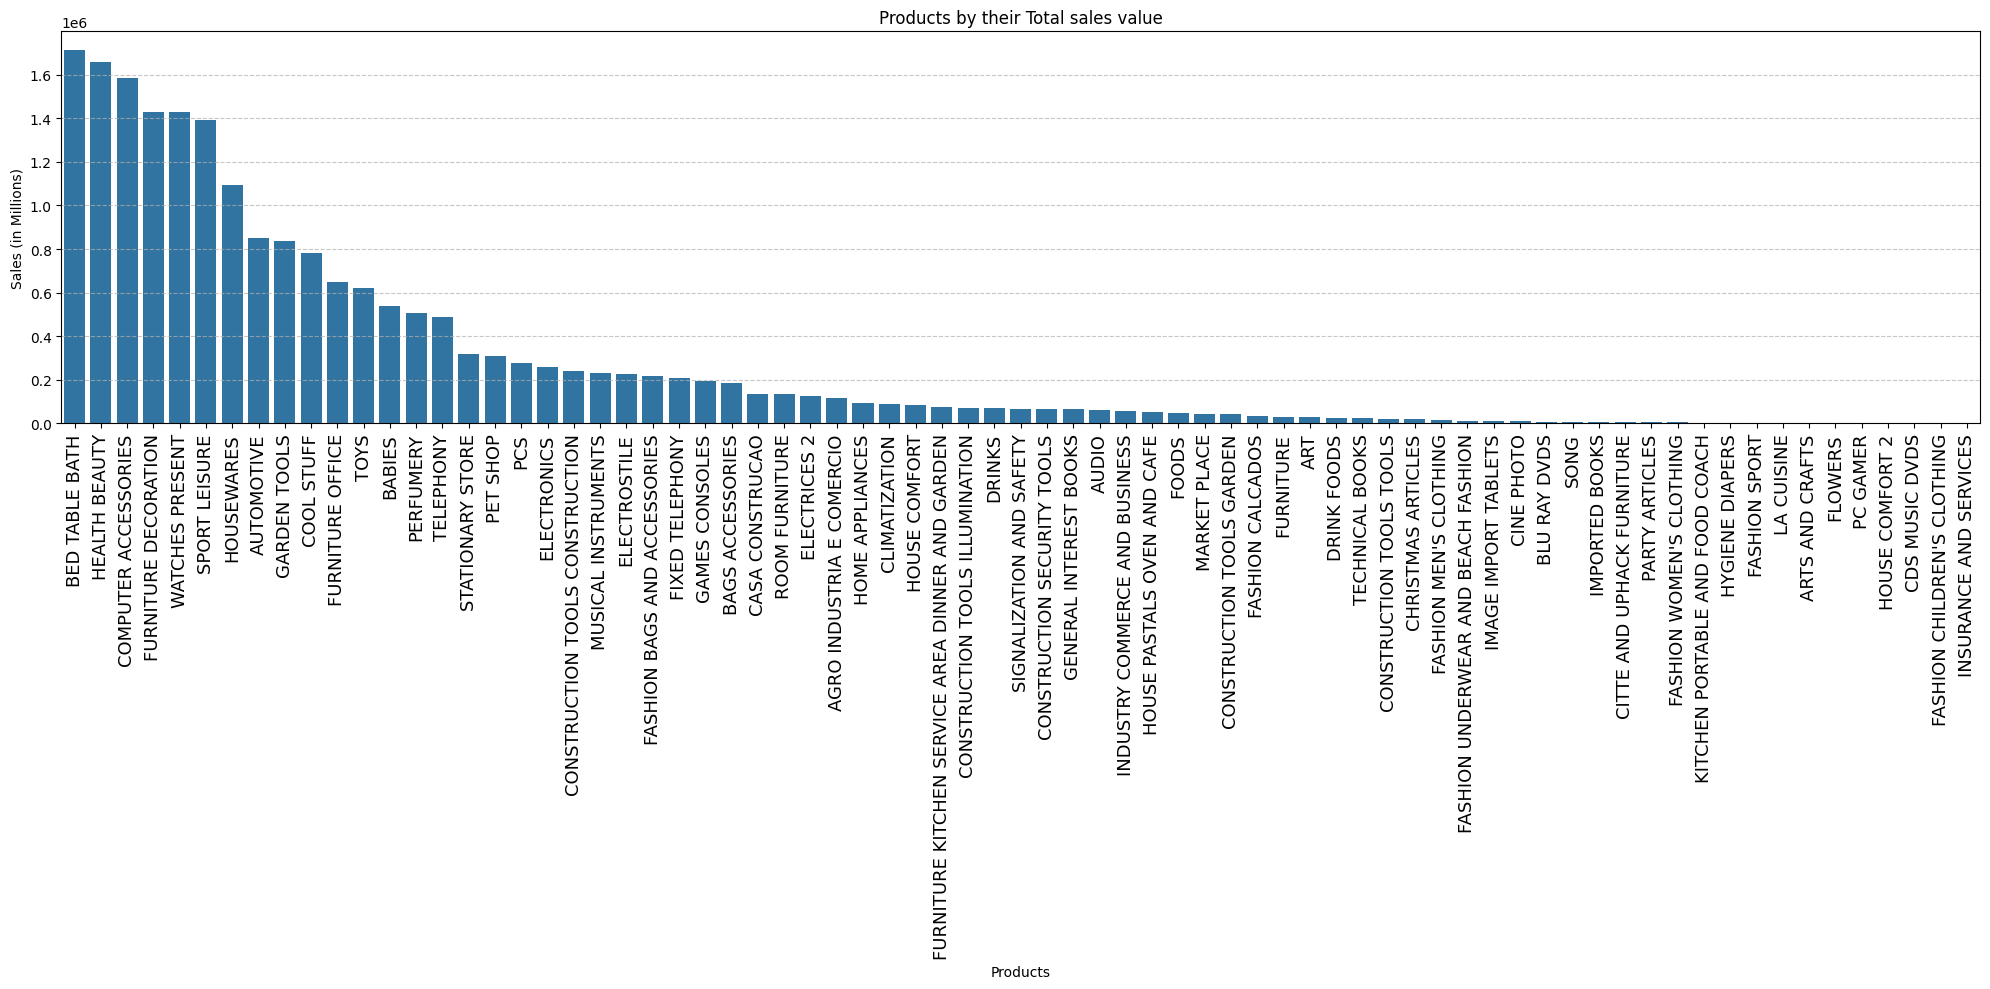

In [9]:
plt.figure(figsize=(20, 10))

sns.barplot(x='product_category', y='sales', data=df)

plt.xlabel('Products')
plt.ylabel('Sales (in Millions)')
plt.title('Products by their Total sales value')
plt.xticks(rotation=90,
           ha='center',
           fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Calculate the percentage of orders that were paid in more than 1 installments.

In [10]:
query = """
    SELECT (SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END)/COUNT(*)) * 100
    FROM payments
"""

data = query_result(query)

In [11]:
print(f"The percentage of orders that were paid in more than 1 installments is: {round(float(data[0][0]), 2)}%")

The percentage of orders that were paid in more than 1 installments is: 49.42%


### Count the number of customers from each state.

In [12]:
query = """
    SELECT customer_state, count(customer_id)
    FROM customers
    GROUP BY customer_state
"""

data = query_result(query)

In [13]:
df = pd.DataFrame(data, columns = ['State', 'Customer_Count']).sort_values(by='Customer_Count', ascending=False)
df

,State,Customer_Count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045
1,SC,3637
9,BA,3380
13,DF,2140
8,ES,2033
7,GO,2020


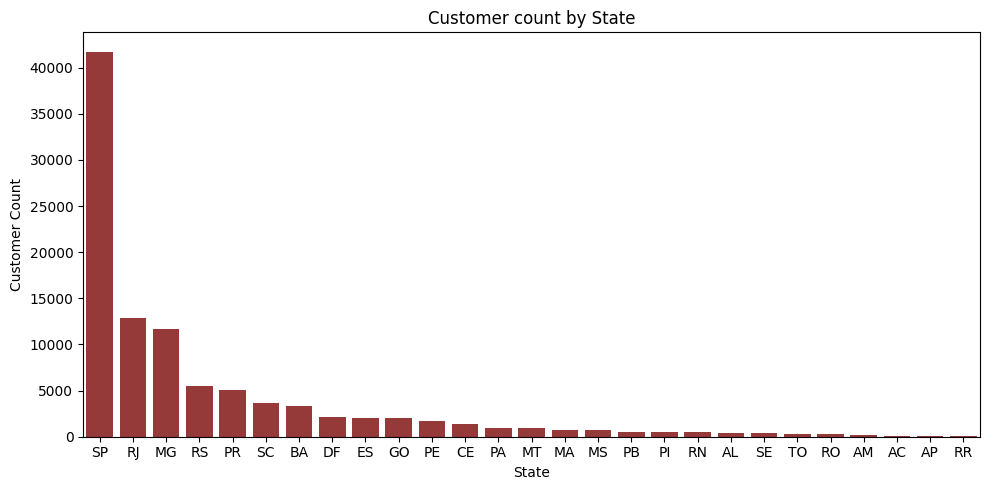

In [14]:
plt.figure(figsize=(10,5))

sns.barplot(x=df['State'], y=df['Customer_Count'], data=df, color="brown")

plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Customer count by State")
plt.tight_layout()
plt.show()

### Calculate the number of orders per month in 2018

In [15]:
query = """
    SELECT 
    	MONTHNAME(order_purchase_timestamp) AS months, 
        COUNT(order_id) as order_count
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2018
    GROUP BY MONTHNAME(order_purchase_timestamp)
"""

data = query_result(query)

In [16]:
df = pd.DataFrame(data, columns=['Months', 'Order_Count']).sort_values(by='Months', ascending=True)
df

,Months,Order_Count
7,April,6939
1,August,6512
2,February,6728
5,January,7269
0,July,6292
3,June,6167
4,March,7211
6,May,6873
9,October,4
8,September,16


In [17]:
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October'
]

df['Months'] = pd.Categorical(df['Months'], categories=month_order, ordered=True)

df = df.sort_values('Months').reset_index(drop=True)
df

,Months,Order_Count
0,January,7269
1,February,6728
2,March,7211
3,April,6939
4,May,6873
5,June,6167
6,July,6292
7,August,6512
8,September,16
9,October,4


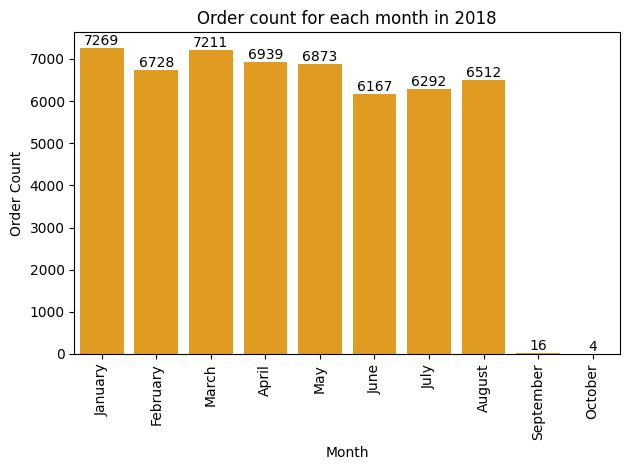

In [18]:
plt.figure()

ax = sns.barplot(x=df['Months'], y=df['Order_Count'], data=df, color="orange")
ax.bar_label(ax.containers[0])
plt.title("Order count for each month in 2018")
plt.xlabel("Month")
plt.ylabel("Order Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Find the average number of products per order, grouped by customer city.

In [19]:
query = """
    WITH count_per_order AS
    (SELECT o.order_id, o.customer_id, COUNT(oi.order_id) AS product_count
    FROM orders AS o
    JOIN order_items AS oi
    	ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id)
    
    SELECT c.customer_city, AVG(cpo.product_count) AS avg_orders
    FROM customers AS c
    JOIN count_per_order AS cpo
    	ON c.customer_id = cpo.customer_id
    GROUP BY c.customer_city;
"""

data = query_result(query)

In [20]:
df = pd.DataFrame(data, columns=['Customer_City', 'Average_products_per_Order']).sort_values(by='Average_products_per_Order', ascending=False)
df.head(10)

,Customer_City,Average_products_per_Order
3574,padre carvalho,7.0000
1255,celso ramos,6.5000
3120,datas,6.0000
3717,candido godoi,6.0000
3863,matias olimpio,5.0000
2912,teixeira soares,4.0000
2717,morro de sao paulo,4.0000
3045,curralinho,4.0000
3841,cidelandia,4.0000
3910,picarra,4.0000


In [21]:
df['Customer_City'].nunique()

4110

### Calculate the percentage of total revenue contributed by each product category.

In [22]:
query = """
    SELECT 
    	UPPER(pr.product_category) AS product_category, 
        ROUND((SUM(pa.payment_value) / (SELECT SUM(payment_value) FROM payments))*100, 2) AS percent_sales
    FROM order_items AS oi
    JOIN payments AS pa
    	ON oi.order_id = pa.order_id
    JOIN products AS pr
    	ON oi.product_id = pr.product_id
    GROUP BY pr.product_category
    ORDER BY percent_sales DESC    
"""

data = query_result(query)

In [23]:
df = pd.DataFrame(data, columns=['product_category', 'percent_total_sales'])
df

,product_category,percent_total_sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


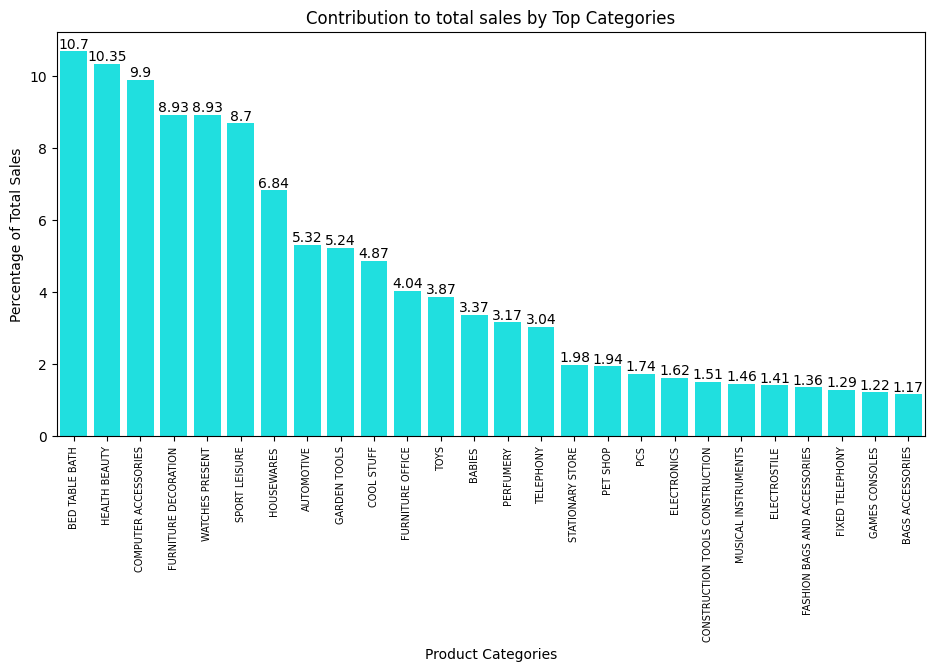

In [24]:
# Let's plot all categories that has contributed atleast 1% of the total sales.

df_top = df[df["percent_total_sales"] >= 1]

plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_top['product_category'], y=df_top['percent_total_sales'], data=df_top, color="aqua")
ax.bar_label(ax.containers[0])
plt.title("Contribution to total sales by Top Categories")
plt.xlabel("Product Categories")
plt.ylabel("Percentage of Total Sales")
plt.tight_layout()
plt.xticks(rotation=90, fontsize=7)
plt.show()

### Identify the correlation between product price and the number of times a product has been purchased.

In [25]:
query = """
    SELECT 
    	p.product_category, 
    	ROUND(AVG(oi.price), 2) AS price,
        COUNT(oi.product_id) AS count
    FROM order_items AS oi
    JOIN products AS p
    	ON oi.product_id = p.product_id
    GROUP BY p.product_category;
"""

data = query_result(query)

In [26]:
df = pd.DataFrame(data, columns=['product_category', 'average_price', 'order_count'])
df

,product_category,average_price,order_count
0,HEALTH BEAUTY,130.16,9670
1,sport leisure,114.34,8641
2,Cool Stuff,167.36,3796
3,computer accessories,116.51,7827
4,Watches present,201.14,5991
...,...,...,...
69,flowers,33.64,33
70,Kitchen portable and food coach,264.57,15
71,House Comfort 2,25.34,30
72,CITTE AND UPHACK FURNITURE,114.95,38


In [27]:
print(f"The correlation between the price and order count is {round(float(df[['average_price', "order_count"]].corr().iloc[1,0]),2)}")

The correlation between the price and order count is -0.11


### Calculate the total revenue generated by each seller, and rank them by revenue.

In [28]:
query = """
    SELECT *, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rnk FROM
    (SELECT 
    	oi.seller_id,
        ROUND(SUM(pa.payment_value), 2) as revenue
    FROM order_items AS oi
    JOIN payments as pa
    	ON oi.order_id = pa.order_id
    GROUP BY oi.seller_id) AS a;
"""

data = query_result(query)

In [29]:
df = pd.DataFrame(data, columns=['seller_id', 'revenue', 'rank']).head(20)
df

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


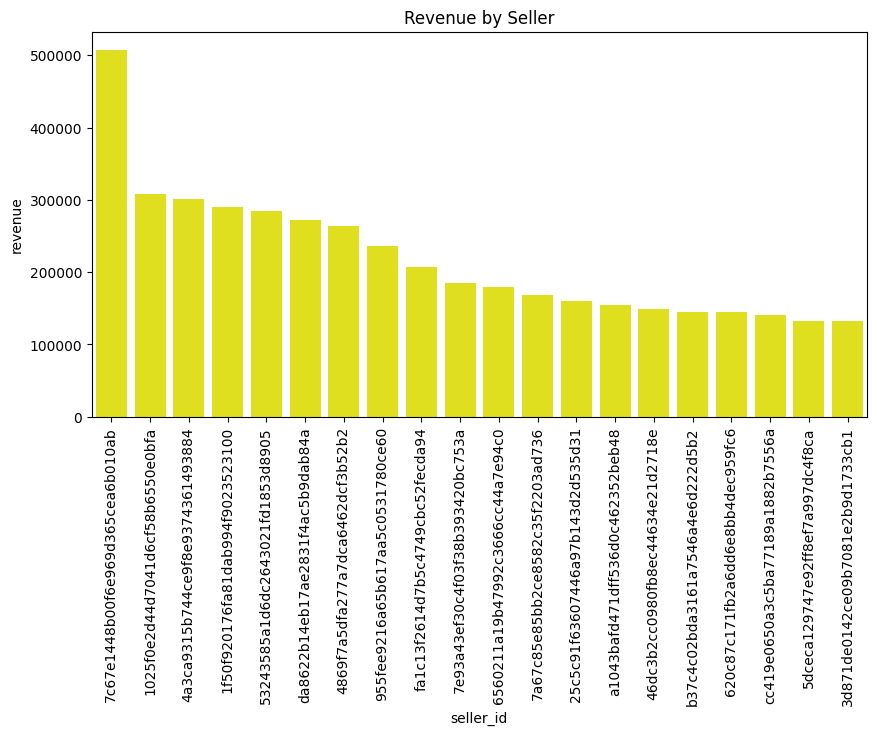

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x=df['seller_id'], y=df['revenue'], data=df, color='yellow')
plt.title("Revenue by Seller")
plt.xticks(rotation=90, fontsize = 10)
plt.show()

### Calculate the moving average of order values for each customer over their order history.

In [31]:
query = """
    SELECT 
    	customer_id, 
        order_purchase_timestamp, 
        payment, 
        AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp 
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
    FROM
    (SELECT 
    	o.customer_id, 
    	o.order_purchase_timestamp, 
        pa.payment_value AS payment
    FROM orders AS o
    JOIN payments AS pa
    	ON o.order_id = pa.order_id) AS a;
"""

data = query_result(query)

In [32]:
df = pd.DataFrame(data, columns=['customer_id', 'order_purchase_timestamp', 'payment', 'mov_avg'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df.sort_values(by=['customer_id','order_purchase_timestamp'], ascending=[False,True])
df.head(20)

,customer_id,order_purchase_timestamp,payment,mov_avg
103885,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103879,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,0.640000
103880,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,5.065000
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103878,fffcb937e9dd47a13f05ecb8290f4d3e,2018-03-17 00:55:27,91.91,91.910004
103877,fffc22669ca576ae3f654ea64c8f36be,2017-06-30 11:21:11,101.56,101.559998
103876,fffb97495f78be80e2759335275df2aa,2018-01-16 14:51:35,61.01,61.009998


### Calculate the cumulative sales per month for each year.

In [33]:
query = """
    SELECT 
    	years, 
        months, 
        payment, 
        ROUND(SUM(payment) OVER (ORDER BY years, months), 2) as cumulative_sales
    FROM
    (SELECT 
    	YEAR(o.order_purchase_timestamp) AS years, 
        MONTH(o.order_purchase_timestamp) AS months, 
        ROUND(SUM(pa.payment_value), 2) AS payment
    FROM orders AS o
    JOIN payments AS pa
    	ON o.order_id = pa.order_id
    GROUP BY years, months
    ORDER BY years, months) AS a;
"""

data = query_result(query)

In [34]:
df = pd.DataFrame(data, columns=['years','months','payment','cumulative_sales']).sort_values(by=['years','months'])
df.head(20)

,years,months,payment,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [35]:
df['year_month'] = df['years'].astype(str) + '-' + df['months'].astype(str)
df['year_month'] = pd.to_datetime(df['year_month'])
df = df.sort_values(by='year_month')

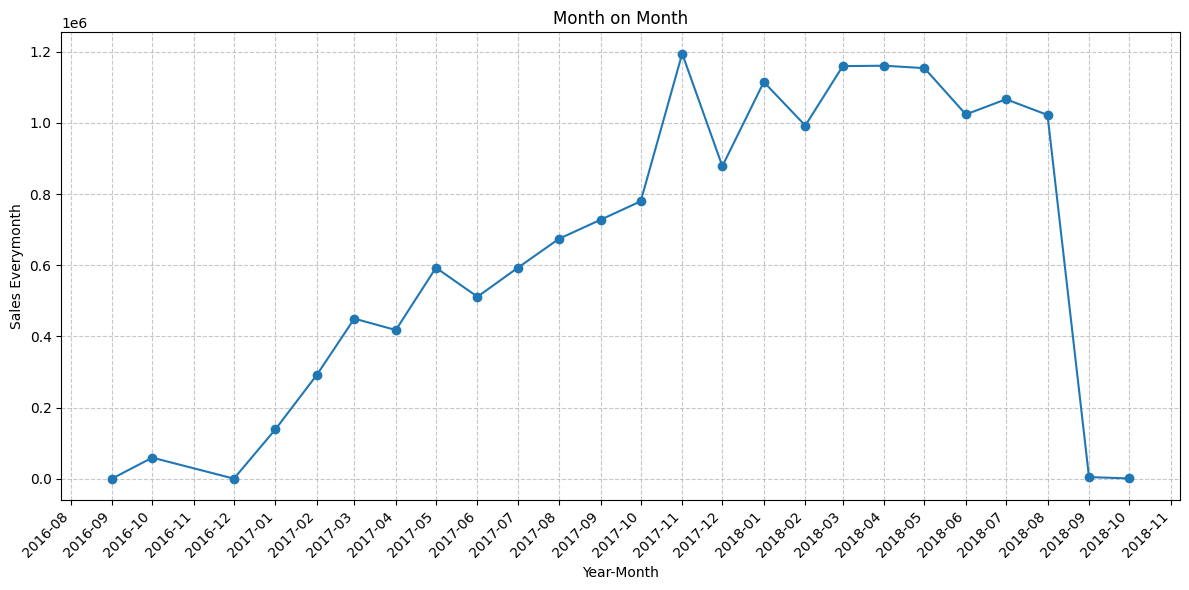

In [36]:
plt.figure(figsize=(12, 6))

plt.plot(df['year_month'], df['payment'], marker='o', linestyle='-')

plt.xlabel('Year-Month')
plt.ylabel('Sales Everymonth')
plt.title('Month on Month')
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Calculate the year-over-year growth rate of total sales.

In [37]:
query = """
    WITH a AS
    (SELECT 
    	YEAR(o.order_purchase_timestamp) AS years,
        ROUND(SUM(pa.payment_value), 2) AS total_sales
    FROM orders AS o
    JOIN payments AS pa
    	ON o.order_id = pa.order_id
    GROUP BY years
    ORDER BY years)
    
    SELECT 
    	years, 
        ROUND(((total_sales - LAG(total_sales, 1) OVER(ORDER BY years)) / LAG(total_sales, 1)
        OVER(ORDER BY years)) * 100, 2) AS yoy_growth
    FROM a;
"""

data = query_result(query)

In [38]:
df = pd.DataFrame(data, columns=['years', 'yoy%_growth']).sort_values(by='years')
df

,years,yoy%_growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [39]:
query = """
    WITH
    a AS 
    (SELECT 
    	cu.customer_id,
        min(o.order_purchase_timestamp) as first_order_timestamp
    FROM orders AS o
    JOIN customers AS cu
    	ON o.customer_id = cu.customer_id
    GROUP BY cu.customer_id),
    
    b AS
    (SELECT 
    	a.customer_id,
        COUNT(DISTINCT o.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders AS o
    	ON a.customer_id = o.customer_id
        AND o.order_purchase_timestamp > first_order_timestamp
        AND o.order_purchase_timestamp < DATE_ADD(first_order_timestamp, INTERVAL 6 MONTH)
    GROUP BY a.customer_id)
    
    SELECT 100 * (COUNT(DISTINCT a.customer_id)/ COUNT(DISTINCT b.customer_id)) AS retaintion_rate
    FROM a
    LEFT JOIN b
    	ON a.customer_id = b.customer_id;
"""

data = query_result(query)

In [40]:
df = pd.DataFrame(data, columns=['retaintion_rate'])
df

,retaintion_rate
0,None


Since None of the customers repeted, the retaintion rate is none.

### Identify the top 3 customers who spent the most money in each year.

In [41]:
query = """
    SELECT a.years, a.customer_id, a.total_payment, a.d_rank
    FROM
    (SELECT
    	YEAR(o.order_purchase_timestamp) AS years,
    	o.customer_id,
    	ROUND(SUM(p.payment_value), 2) AS total_payment,
    	DENSE_RANK() OVER (PARTITION BY YEAR(o.order_purchase_timestamp) 
        ORDER BY SUM(p.payment_value) DESC) AS d_rank
    FROM orders AS o 
    JOIN payments AS p
    	ON p.order_id = o.order_id
    GROUP BY YEAR(o.order_purchase_timestamp), o.customer_id) AS a
    WHERE a.d_rank <= 3
    ORDER BY a.years, a.total_payment DESC;
"""

data = query_result(query)

In [42]:
df = pd.DataFrame(data, columns=['years', 'customer_id', 'total_payment', 'rank'])
df

,years,customer_id,total_payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


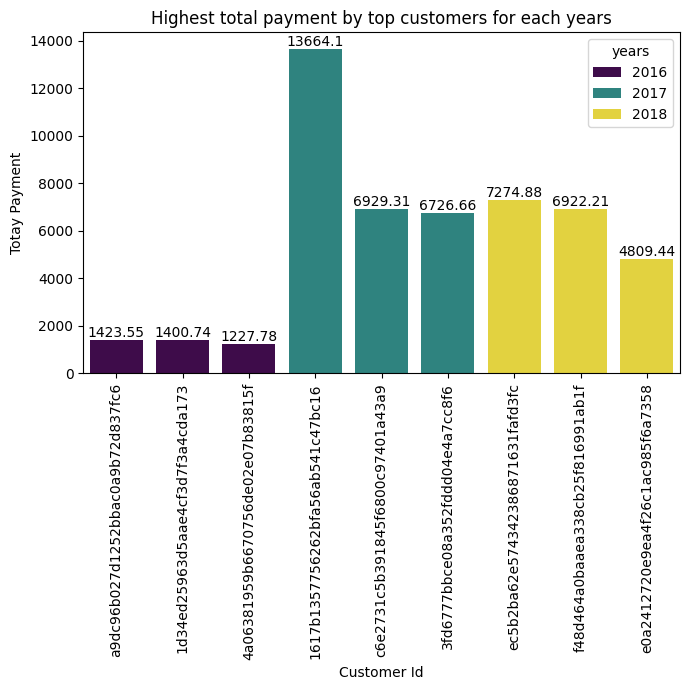

In [43]:
plt.figure(figsize=(7,7))
ax = sns.barplot(x=df['customer_id'], y=df['total_payment'], data=df, hue='years', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("Customer Id")
plt.ylabel("Totay Payment")
plt.title("Highest total payment by top customers for each years")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()